# Can we accurately predict precipitation rates in London?

Section 004, Group 34: Aronn Grant Laurel Y., Mina Chen, Anabel Iris Eliora Hartanto, Farhan Ihsas Hoque

## Introduction

London is one of the world’s busiest cities, so rain can lead to significant disruptions in traffic. In this study, we will use a dataset by the European Climate Assessment (https://www.ecad.eu/dailydata/index.php) and predict precipitation rates in London using K-nearest neighbors regression. The dataset obtained covers daily weather measurements recorded by a London weather station with each row being daily observation from 1979-2020. 

The dataset contains 10 columns:

`date` : Measurement date - (int)

`cloud_cover` : Cloud cover - (oktas)

`sunshine` : Sunshine measurement (hrs)

`global_radiation` : Irradiance measurement  (W/m2)

`max_temp` : Maximum temperature(°C) 

`mean_temp` : Mean temperature (°C) 

`min_temp` : Minimum temperature (°C) 

`precipitation` : Precipitation (mm)

`pressure` : Pressure (Pa) 

`snow_depth` : Snow depth (cm)

We will be experimenting with all weather measurements to determine which factor has the best correlation with precipitation and support our findings with scientific reasoning for the prediction of precipitation levels in London.

## Preliminary exploratory data analysis

In [2]:
# Download Package kknn
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [21]:
# Load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(kknn)

First, we use `read_csv()` to read the dataset, and `head` to read the first few rows of **weather_data**.

In [4]:
library(RCurl)
library(readr)
url <- "https://raw.githubusercontent.com/LaoAronn/ds_project/main/data/london_weather.csv"
weather_data <- read_csv(url)
head(weather_data)


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete


Rows: 15341 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): date, cloud_cover, sunshine, global_radiation, max_temp, mean_temp...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


date     cloud_cover sunshine global_radiation max_temp mean_temp min_temp
1 19790101 2           7.0      52                2.3     -4.1      -7.5    
2 19790102 6           1.7      27                1.6     -2.6      -7.5    
3 19790103 5           0.0      13                1.3     -2.8      -7.2    
4 19790104 8           0.0      13               -0.3     -2.6      -6.5    
5 19790105 6           2.0      29                5.6     -0.8      -1.4    
6 19790106 5           3.8      39                8.3     -0.5      -6.6    
  precipitation pressure snow_depth
1 0.4           101900   9         
2 0.0           102530   8         
3 0.0           102050   4         
4 0.0           100840   2         
5 0.0           102250   1         
6 0.7           102780   1

Then, we use the `select()` function to limit the dataset to include only our weather predictors and the precipitation level. We will also use `na.omit()` function to remove all observations with any NA data and `rename` function to rename the columns for our Recipe to work.

In [5]:
# Using only data from 2010 to 2020
weather_year <- weather_data |>
                    mutate(year = round(date / 10000)) |>
                    filter(year >= 2010)

weather_filtered <- na.omit(weather_year)

weather_filtered <- weather_filtered |>
                        rename(cloud.cover = cloud_cover,
                               global.radiation = global_radiation,
                               mean.temp = mean_temp)
                        
weather_filtered <- weather_filtered |>
                        select(cloud.cover, sunshine, global.radiation, mean.temp, pressure, precipitation)

head(weather_filtered)

cloud.cover sunshine global.radiation mean.temp pressure precipitation
1 2           6.4      49                1.6      100560   0.0          
2 4           5.9      48                1.3      101550   0.0          
3 2           3.9      39                1.2      102280   0.0          
4 0           6.3      50               -2.5      101960   0.2          
5 7           0.1      15               -1.9      100520   2.0          
6 7           0.0      13               -0.9      100290   2.6

Now, we will begin train the model by splitting **weather_data** into training and testing set with a proportion of 75% and 25% respectively. Since we are dealing with a time series data set, we will use `initial_time_split` function so it will take the first 75% data in the data frame instead of a randomized selection.

In [6]:
weather_split <- initial_time_split(weather_filtered, prop = 0.75, strata = precipitation)
weather_split

weather_training <- training(weather_split)

weather_testing <- testing(weather_split)

<Training/Testing/Total>
<2459/820/3279>

Using the training data, we create a table that displays the **correlation coefficient** between all factors with the Precipitation to find the strength of relationship between them.

In [7]:
# create matrix with 4 columns and 4 rows
data = matrix(c(cor(weather_training$precipitation, weather_training$cloud.cover),
                cor(weather_training$precipitation, weather_training$sunshine),
                cor(weather_training$precipitation, weather_training$global.radiation),
                cor(weather_training$precipitation, weather_training$mean.temp),
                cor(weather_training$precipitation, weather_training$pressure)
                ), ncol=5, byrow=TRUE)
 
# specify the column names and row names of matrix
colnames(data) = c('Cloud Cover','Sunshine','Global Radiation','Mean Temperature', 'Pressure')
rownames(data) <- c('Precipitation')
 
# assign to table
final_table = as.matrix(data)
 
# display
final_table

Cloud Cover Sunshine   Global Radiation Mean Temperature
Precipitation 0.2168178   -0.2227328 -0.1550186       -0.005725951    
              Pressure  
Precipitation -0.3251482

Furthermore, we will also plot graphs to compare the relationship between each selected weather factors and the precipitation levels.

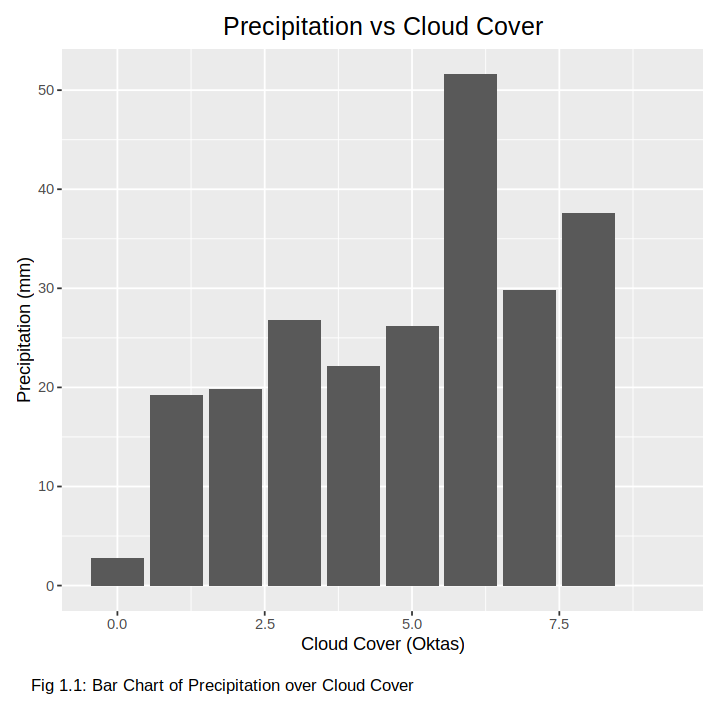

In [49]:
options(repr.plot.height = 6, repr.plot.width = 6)
cloud_rain_plot <- weather_training |>
                    ggplot(aes(x = cloud.cover, y = precipitation) ) +
                    geom_bar(stat = "identity", position = "dodge") + 
                    ggtitle("Precipitation vs Cloud Cover") +
                    labs(x = "Cloud Cover (Oktas)", y = "Precipitation (mm)", tag = "Fig 1.1: Bar Chart of Precipitation over Cloud Cover") +
                    theme(plot.title = element_text(hjust = 0.5, size = 15),
                          plot.margin = margin(t = 10, r = 10, b = 40, l = 10),
                          plot.tag = element_text(size = 10),
                          plot.tag.position = c(0.3, -0.05))
cloud_rain_plot

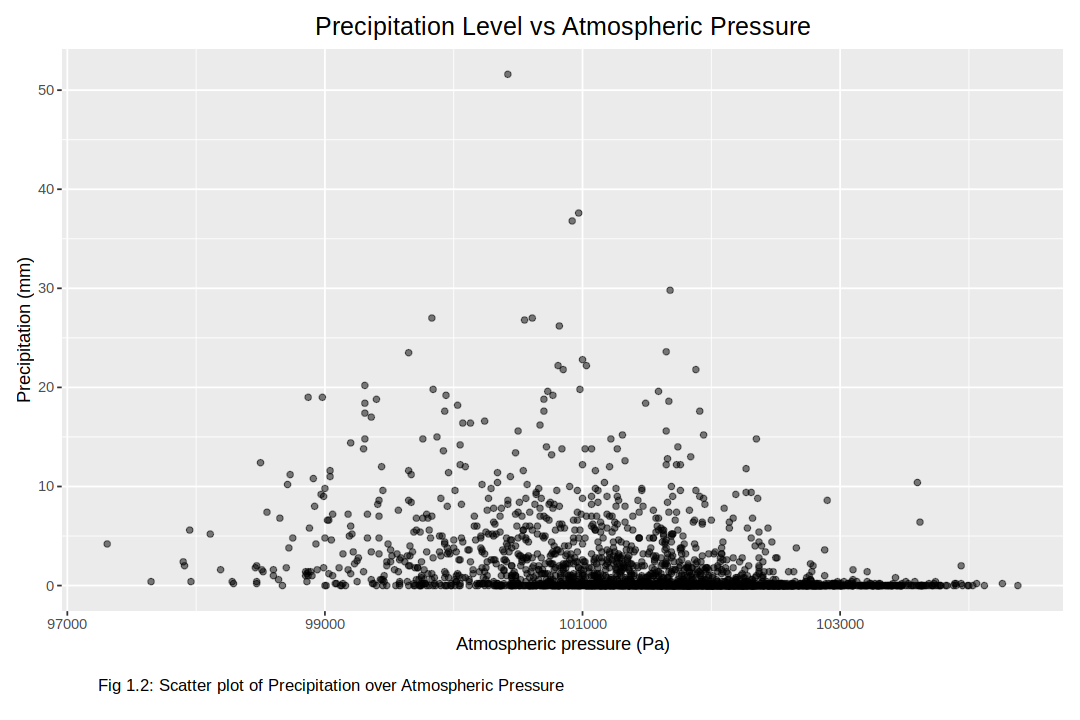

In [47]:
options(repr.plot.height = 6, repr.plot.width = 9)

pressure_rain_plot <- weather_training |>
                    ggplot( aes(x = pressure, y = precipitation) ) +
                    geom_point(alpha = 0.5) + 
                    ggtitle("Precipitation Level vs Atmospheric Pressure") +
                    labs(x = "Atmospheric pressure (Pa)", y = "Precipitation (mm)",
                         tag = "Fig 1.2: Scatter plot of Precipitation over Atmospheric Pressure") +
                    theme(plot.title = element_text(hjust = 0.5, size = 15),
                          plot.margin = margin(t = 10, r = 10, b = 40, l = 10),
                          plot.tag = element_text(size = 10),
                          plot.tag.position = c(0.3, -0.05))
pressure_rain_plot

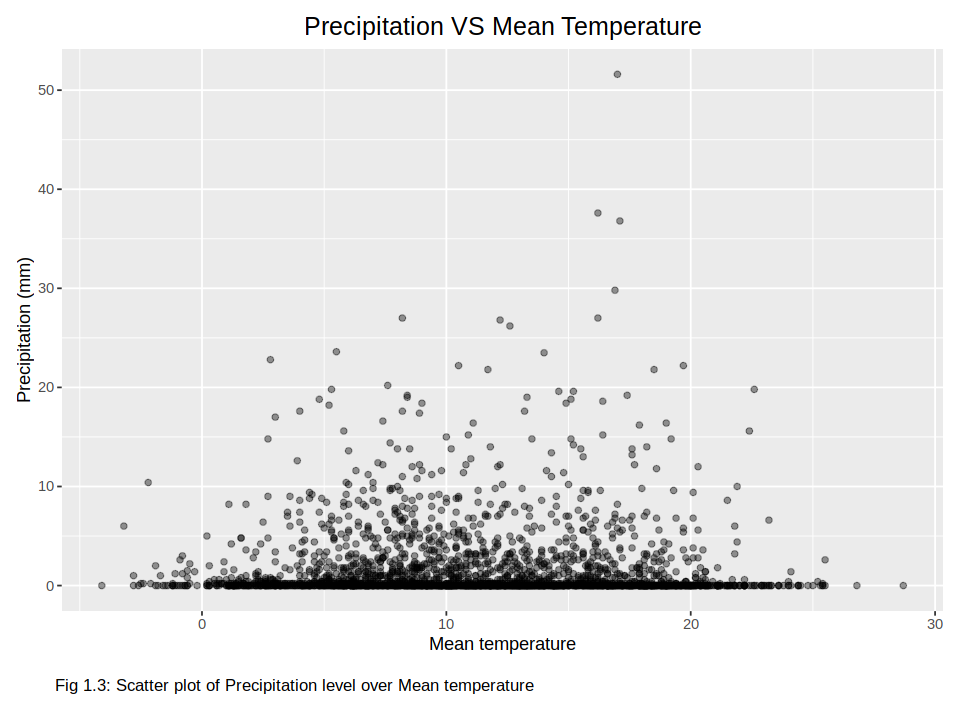

In [48]:
options(repr.plot.height = 6, repr.plot.width = 8)

temp_rain_plot <- weather_training |>
                    ggplot(aes(x = mean.temp, y = precipitation)) +
                    geom_point(alpha = 0.4) +
                    ggtitle("Precipitation VS Mean Temperature") +
                    labs(x = "Mean temperature", y = "Precipitation (mm)",
                         tag = "Fig 1.3: Scatter plot of Precipitation level over Mean temperature") +
                    theme(plot.title = element_text(hjust = 0.5, size = 15),
                          plot.margin = margin(t = 10, r = 10, b = 40, l = 10),
                          plot.tag = element_text(size = 10),
                          plot.tag.position = c(0.3, -0.05))
temp_rain_plot

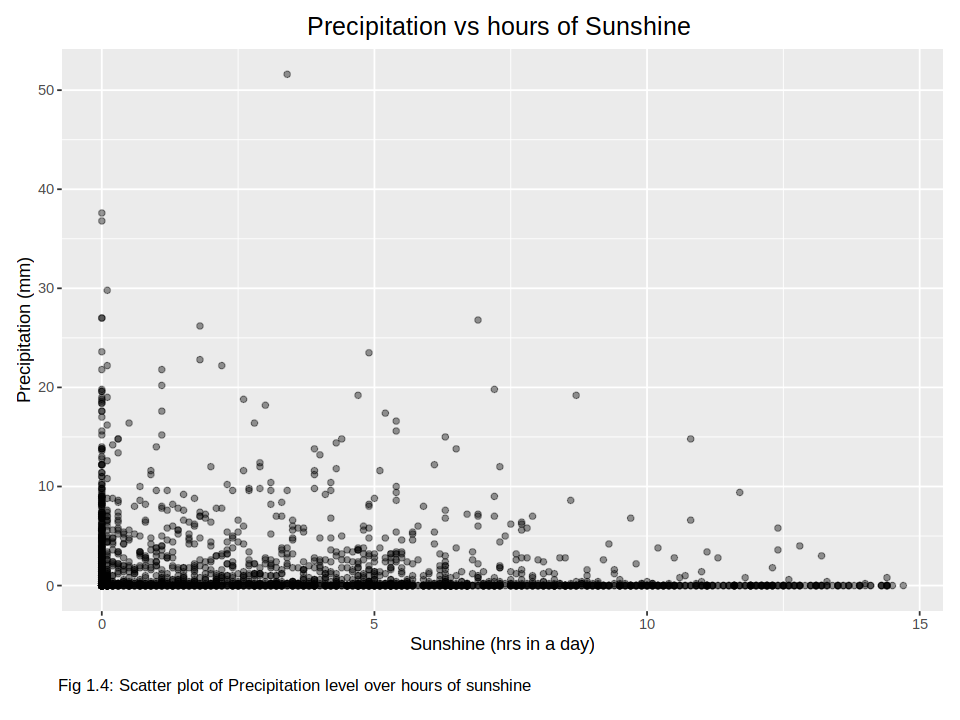

In [53]:
options(repr.plot.height = 6, repr.plot.width = 8)
sun_rain_plot <- weather_training |>
                    ggplot( aes(x = sunshine, y = precipitation) ) +
                    geom_point(alpha = 0.4) + 
                    ggtitle("Precipitation vs hours of Sunshine ") +
                    labs(x = "Sunshine (hrs in a day)", y = "Precipitation (mm)",
                        tag = "Fig 1.4: Scatter plot of Precipitation level over hours of sunshine") +
                    theme(plot.title = element_text(hjust = 0.5, size = 15),
                          plot.margin = margin(t = 10, r = 10, b = 40, l = 10),
                          plot.tag = element_text(size = 10),
                          plot.tag.position = c(0.3, -0.05))
sun_rain_plot

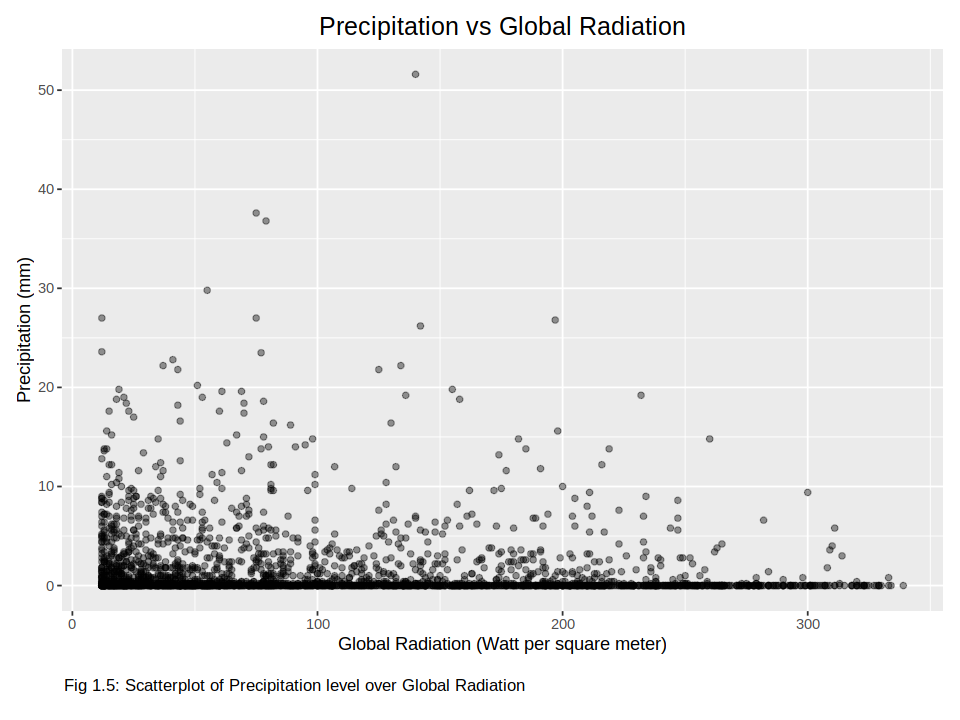

In [55]:
options(repr.plot.height = 6, repr.plot.width = 8)

radiation_rain_plot <- weather_training |>
                    ggplot( aes(x = global.radiation, y = precipitation) ) +
                    geom_point(alpha = 0.4) + 
                    ggtitle("Precipitation vs Global Radiation") +
                    labs(x = "Global Radiation (Watt per square meter)", y = "Precipitation (mm)",
                         tag = "Fig 1.5: Scatterplot of Precipitation level over Global Radiation") +
                    theme(plot.title = element_text(hjust = 0.5, size = 15),
                          plot.margin = margin(t = 10, r = 10, b = 40, l = 10),
                          plot.tag = element_text(size = 10),
                          plot.tag.position = c(0.3, -0.05))
radiation_rain_plot

### Findings from the plots
The plots above visualizes the relationship between the level of precipitation and each predictor in this analysis. 

- For `cloud.cover`, the plot shows an increasing trend between the precipitation and increasing cloud cover. 
- The scatter plot with `pressure` shows a negative relationship between atmospheric pressure and precipitation. 
- The scatter plot with `mean.temp` alone does not allow us to conclude a correlation between average temperatures and precipitation levels.
- The scatter plot with `sunshine` shows a negative relationship between hours of sunshine and the levels of precipitation. 
- The scatter plot with `global.radiation` shows a negative relationship between global radiation measurements and the levels of precipitation. 

### Scientific Reasoning
1. Cloud cover (oktas):
In the data, cloud cover is measured in oktas, from a range of 0 to 9 oktas. Cloud cover is the measurement of the amount of sky covered by clouds in any given location. Generally, cloud cover is positively associated with precipitation levels. Less cloud cover is associated with a high-pressure system, which signals either zero or little precipitation. Increasing cloud cover frequency translates to increasing precipitation. 

2. Pressure (Pa):
Pressure is inversely correlated with precipitation levels. In a high-pressure system, the high-pressure levels prevent cloud formation, therefore resulting in less precipitation. The low-pressure system enables cloud formation, which in turn leads to higher precipitation levels. 

3. Mean temperature (°C):
Temperature has a positive relationship with precipitation. As the average temperatures of the Earth’s surface rise, more evaporation occurs, increasing cloud formation, thus, increasing precipitation levels.

4. Sunshine (hours):
Sunshine has a negative correlation with precipitation levels. Higher sunshine measurements are correlated with less precipitation. More hours of sunshine are associated with high-pressure systems, which inhibits cloud formation and precipitation.  

5. Global Radiation (W/m^2):
Due to different regional variables that influence the relationship between global radiation and precipitation levels, there is no definitive relationship and a large variability in the data. Therefore, global radiation may not serve as an effective factor in predicting precipitation levels in this analysis. 

Overall, cloud cover and mean temperature have a positive relationship with precipitation, the increase in cloud cover and mean temperature would cause an increase in the precipitation. Pressure and sunshine have a negative relationship with precipitation, the increase of pressure and sunshine would cause a decrease in the precipitation.


## K-nearest Neighbors Regression Model

### Tuning the Model

In [16]:
weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("regression")

weather_recipe <- recipe(precipitation ~ cloud.cover + sunshine + global.radiation + mean.temp + pressure, data = weather_training) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

weather_vfold <- vfold_cv(weather_training, v = 5, strata = precipitation)

weather_workflow <- workflow() |>
                add_recipe(weather_recipe) |>
                add_model(weather_spec) |>
                fit(data = weather_training)
weather_workflow

Warning message:
“tune samples were requested but there were 2459 rows in the data. 2454 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 2.277702
Minimal mean squared error: 14.4375
Best kernel: rectangular
Best k: 2454

In [1]:
gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))

weather_results <- weather_workflow |>
  tune_grid(resamples = weather_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")


options(repr.plot.width = 6, repr.plot.height = 6)
weather_results_plot <- ggplot(weather_results, aes(x = neighbors, y = mean)) +
                          geom_line() +
                          labs(x = "Number of Neighbors", y = "RMSE", title = "Tuning Results")
weather_results_plot

ERROR: Error in tibble(neighbors = seq(from = 1, to = 200, by = 3)): could not find function "tibble"


In [21]:
# show only the row of minimum RMSPE
weather_min <- weather_results |>
  filter(mean == min(mean))
weather_min

# Smallest RMSPE when K = 31
k_min <- weather_min |>
            pull(neighbors)
k_min

neighbors .metric .estimator mean   n std_err   .config              
1 31        rmse    standard   3.4573 5 0.1568447 Preprocessor1_Model11

[1] 31

### Evaluating the Model

In [25]:
weather_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
                        set_engine("kknn") |>
                        set_mode("regression")

weather_best_fit <- workflow() |>
                        add_recipe(weather_recipe) |>
                        add_model(weather_best_spec) |>
                        fit(data = weather_training)

#Evaluate the Model on the Testing Set
weather_summary <- weather_best_fit |>
                        predict(weather_testing) |>
                        bind_cols(weather_testing) |>
                        metrics(truth = precipitation, estimate = .pred) |>
                        filter(.metric == 'rmse')
weather_summary

#Final rmse estimate = 3.212616 (mm)

.metric .estimator .estimate
1 rmse    standard   3.212616

Final model test error is 3.212616 mm. This error is similar to the RMPSE estimate of our tuned model, so the model generalizes well to new data it has never encountered before (testing set). However, the accuracy of this model depends on the application.

# Methods

##  Explain how you will conduct either your data analysis and which variables/columns you will use.
Aside from date and snow depth, we will consider all other weather conditions which include cloud cover, sunshine, global radiation, mean temperature, precipitation and pressure.
 
We do not consider snow depth because there is insufficient correlation between snow depth and precipitation with only 140 outlier data points among ​15342 observations while there is no snow (snow depth = 0cm) for the rest. 

Based on the plots between precipitation and other weather factors, we will take global radiation into consideration as they display a strong relationship.

##  Explain how you will conduct either your data analysis and which variables/columns you will use.
Aside from date and snow depth, we will consider all other weather conditions which include cloud cover, sunshine, global radiation, mean temperature, precipitation and pressure.
 
We do not consider snow depth because there is insufficient correlation between snow depth and precipitation with only 140 outlier data points among ​15342 observations while there is no snow (snow depth = 0cm) for the rest. 

Based on the plots between precipitation and other weather factors, we will take global radiation into consideration as they display a strong relationship.

## Describe at least one way that you will visualize the results
To compare relationships between variables, we use scatter plots as a way to visualize the results as it is the most effective for quantitative variables. For our regression model, we will visualize the testing dataset in a scatter plot, allowing us to assess the model’s accuracy, as we compare actual data with predicted data. 


# Expected Outcomes and Significance

From our analysis, we expect to find that precipitation levels can be predicted dependent on other correlated measurements of weather factors. We specifically anticipate that higher levels of precipitation occur in specific weather conditions, such as lower mean temperature, reduced sunshine and radiation, increased cloud cover, and lower pressure measurements. 

This analysis of historical weather data in London would provide valuable insights into current weather forecasting systems. These findings would also be beneficial in providing a better understanding of environmental processes and the impact of global changes on London’s weather patterns.

This study may lead to several future questions:
Are there any new factors introduced that may be a major factor to predicting precipitation levels? 
Has there been any shifting in factors and model predictability due to global climate change? 
How accurate are current weather forecasting models, how can we improve them?

##  Works Cited

​​‌“Atmospheric Pressure.” Nationalgeographic.org, 2023, education.nationalgeographic.org/resource/atmospheric-pressure/. Accessed 5 Dec. 2023.

Hazir, MHM, et al. “Effect of Agroclimatic Variablity on Land Suitability for Cultivating Rubber (Hevea Brasiliensis) and Growth Performance Assessment in the Tropical Rainforest Climate of Penisular Malasia).” ResearchGate, ResearchGate, 2020, www.researchgate.net/figure/The-relationship-between-average-daily-sunshine-and-average-monthly-precipitation_fig3_339783971. Accessed 5 Dec. 2023.

Mishra, Anoop. K. “On the Linkage between Changes in Cloud Cover and Precipitation Extremes over Central India.” Dynamics of Atmospheres and Oceans, vol. 86, Elsevier BV, June 2019, pp. 163–71, https://doi.org/10.1016/j.dynatmoce.2019.05.002. Accessed 5 Dec. 2023.

‌Temperature and Precipitation, cfpub.epa.gov/roe/indicator_pdf.cfm?i=89. Accessed 5 Dec. 2023. 